# Requirements
* 1.Walk through your model step by step, starting with EDA
    * What are your variables of interest?
    * What outliers did you remove?
    * What types of data imputation did you perform?
* 2.Summarize your statistical analysis, including:
    * model selection
    * implementation
    * evaluation
    * inference


# Capstone – Ageing and Residential Aged Care Facilties

There is a high ageing population in Australia. As such, resources are required to support the ageing population. This project determines if there are sufficient NSW residential aged care facilities in place to support the ageing population.

### The project investigates the following: 
* Sufficent residential beds for people over 65 years currently and in future. 
* The optimal features of a current residential aged care faciltiy for the purpose of opening future residential facilties. 
* The general sentiment towards a residential aged care facility

### Assumptions:
* Future residential beds are based on the level of occupancy against the population of people who are 65 years old and over
* All factors related to the care of the elderly are sufficient and remains constant. An example is the staff to patient ratios. 
* The location of the residential aged care facility may not be the location where a person has lived most of their life. An example would be a person entering residential aged care facility that is located where his/ her children are currently residing. 
* The government funding provided for each residential aged care facility in 2017 does not require adjustment
* The estimated population will have a high fertility rate ie: A_65

### The data sources are from the following:
* Population data from Australian Bureau of Statistics
* List of aged care/ retirement homes from Department of Health – Ageing and Aged Care


### Definitions:
* Residential aged care - A special-purpose facility which provides accommodation and other types of support, including assistance with day-to-day living, intensive forms of care, and assistance towards independent living, to frail and aged residents.

* Residential Bed, Bed or Place - A bed a patient is accommodated 

In [1]:
# Initialize imports
import numpy as np
import scipy.stats as stats
from scipy.stats import t
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
from pandas.io import sql
import sqlite3
import patsy

sns.set_style('whitegrid')

%config InlineBackend.figure_format = 'retina'
%matplotlib inline

In [2]:
# Initialize imports
import sqlite3
sqlite_db = './openlib.db'
conn = sqlite3.connect(sqlite_db) 
c = conn.cursor()
#sepadmin = pd.read_sql('SELECT * FROM separate_admin LIMIT 10', con=conn)
#servicelist = pd.read_sql('SELECT * FROM NSWservicelist LIMIT 10', con=conn)

In [3]:
# In case typing out `sql.read_sql()` is a little too much, we'll create a function shortcut.

c = sqlite3.connect('./openlib.db')

def Q(query, db=c):
    return sql.read_sql(query, db)

# Create a data dictionary

In [4]:
# Create a data dictionary to explain the tables, columns and type of columns
data_dic=pd.DataFrame({'id': [1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26],
                       't_able': ['separate_admin',
                                'separate_admin',
                                'separate_admin',
                                'separate_admin',
                                'separate_admin',
                                'separate_admin',
                                'separate_admin',
                                'separate_admin',
                                'NSWservicelist',
                                'NSWservicelist',
                                'NSWservicelist',
                                'NSWservicelist',
                                'NSWservicelist',
                                'NSWservicelist',
                                'NSWservicelist',
                                'NSWservicelist',
                                'NSWservicelist',
                                'NSWservicelist',
                                'NSWservicelist',
                                'NSWservicelist',
                                'NSWservicelist',
                                'NSWservicelist',
                                'NSWservicelist',
                                'NSWservicelist',
                                'NSWservicelist',
                                'NSWservicelist'],
                       'name': ['state','year','places','occupancy','pctoccupant','A_65','B_65','C_65','Servicename',
                                'PhysicalAddressLine1','PhysicalAddressLine2','PhysicalAddressSuburb','PhysicalAddressState',
                                 'PhysicalAddressPostcode','2015AgedCarePlanningRegion(ACPR)','CareType','ResidentialPlaces',
                                'HomeCarePlace','RestorativeCarePlaces','ProviderName','OrganisationType',
                                'ABSRemoteness','2016-17AustralianGovernmentFunding','Year','Latitude','Longitude'],
                       'description':['Population state',
                                       'Population year',
                                       'The number of residential aged care beds',
                                       'The occupancy levels for each year',
                                       'The percentage occupancy levels based on places for each year',
                                       'Estimated population numbers for people over 65 for high fertility scenario',
                                       'Estimated population numbers for people over 65 for medium fertility scenario',
                                       'Estimated population numbers for people over 65 for low fertility scenario',
                                      'Name of facility',
                                      'Physical address 1 of facility',
                                      'Physical address 2 of facility',
                                      'Physical address suburb of facility',
                                      'The state or territory of the facility',
                                      'Physical postcode of facility',
                                      'The name of the Aged Care Planning Region based on the location of the service delivered',
                                      'Residential aged care facility or Home Care service outlet.',
                                      'Number of beds for residental places',
                                      'Number of places for home care',
                                      'Number of places for restorative care',
                                      'An organisation that operates an aged care service (or multiple services) through a national aged care program',
                                      'The organisation type of an organisation providing aged care services',
                                      'The remoteness category of an area a service was provided to as defined by the Australian Bureau of Statistics',
                                      'Govt funding received for the facility in 2016-2017',
                                      'Year the facility was operating',
                                      'Location latitute of the facility',
                                      'Location longtitute of the facility'],       
                       'type': ['object','int','int','int','int','int','int','int','object','object','object','object',
                                'object','int','object','object','int','int','int','object','object','object','float','int',
                               'float','float']})
                                       
                                       

In [5]:
# Write the data dictionary to SQL Lite database
data_dic.to_sql(name = 'data_dic', con = conn, if_exists = 'replace', index = False)

In [6]:
# Query the data dictionary from the database
data=Q('select * from data_dic')
data.head()

,description,id,name,t_able,type
0,Population state,1,state,separate_admin,object
1,Population year,2,year,separate_admin,int
2,The number of residential aged care beds,3,places,separate_admin,int
3,The occupancy levels for each year,4,occupancy,separate_admin,int
4,The percentage occupancy levels based on place...,5,pctoccupant,separate_admin,int


# Perform EDA

### Below are the following data tables used:
* Total NSW aged care residents from 2008 to 2017
* Estimated total NSW population over and including 65 from 2008 to 2061
* Residential aged care facilities in Australia from 2011 to 2017

### Variables of interest are:
* State
* Year
* Places - The number of residential aged care beds
* Pctplaces - Percentage of places against population
* The occupancy levels for each year
* A_65 Population/ estimated population for high fertility scenario

In [7]:
# Select residential places in NSW and the ageing population

total_NSW=Q('SELECT * FROM separate_admin WHERE separate_admin."state" = "NSW"')
total_NSW.head()

,state,year,places,occupancy,pctoccupant,A_65,B_65,C_65
0,NSW,2008,59034,55315,93.7,961243,961068,960895
1,NSW,2009,60397,55999,92.7,986376,992888,992064
2,NSW,2010,61909,57196,92.4,1019316,1018346,1016765
3,NSW,2011,63044,58596,92.9,1046233,1051435,1048479
4,NSW,2012,63891,59137,92.6,1088287,1092284,1087742


In [8]:
# Select residential aged care facilities in NSW from 2011 to 2017

SQL_STRING = '''

SELECT "PhysicalAddressState","Year",SUM(Residential) AS ResBeds
FROM NSWservicelist
WHERE "PhysicalAddressState"= 'NSW'
GROUP BY "PhysicalAddressState","Year";
'''
NSW_res = pd.read_sql(SQL_STRING, con=conn)
NSW_res

,PhysicalAddressState,Year,ResBeds
0,NSW,2011-2012,83843.0
1,NSW,2012-2013,65814.0
2,NSW,2013-2014,66780.0
3,NSW,2014-2015,67258.0
4,NSW,2015-2016,68228.0
5,NSW,2016-2017,70050.0


### Slicing, dicing and merging tables

In [9]:
# Rename column
NSW_res.rename(columns={'Year':'FinYear'}, inplace=True)

In [10]:
# rename year from string to integer
NSW_res["year"] = NSW_res["FinYear"].map(lambda x: "2012" if "2011-2012" in x 
                                                else "2013" if "2012-2013" in x
                                                else "2014" if "2013-2014" in x
                                                else "2015" if "2014-2015" in x
                                                else "2016" if "2015-2016" in x 
                                                else "2017" if "2016-2017" in x 
                                                else "0")
NSW_res

,PhysicalAddressState,FinYear,ResBeds,year
0,NSW,2011-2012,83843.0,2012
1,NSW,2012-2013,65814.0,2013
2,NSW,2013-2014,66780.0,2014
3,NSW,2014-2015,67258.0,2015
4,NSW,2015-2016,68228.0,2016
5,NSW,2016-2017,70050.0,2017


In [11]:
# merge table
total_NSW = total_NSW.merge(NSW_res,how='left',on=['year'])

In [12]:
# drop state column
total_NSW=total_NSW.drop(['PhysicalAddressState'],axis=1)

In [13]:
# Remove NaN
total_NSW.ResBeds = total_NSW.ResBeds.fillna('')

In [16]:
# convert related columns to numeric

total_NSW['year'] = total_NSW['year'].convert_objects(convert_numeric=True)
total_NSW['places'] = total_NSW['places'].convert_objects(convert_numeric=True)
total_NSW['occupancy'] = total_NSW['occupancy'].convert_objects(convert_numeric=True)
total_NSW['pctoccupant'] = total_NSW['pctoccupant'].convert_objects(convert_numeric=True)
total_NSW['A_65'] = total_NSW['A_65'].convert_objects(convert_numeric=True)
total_NSW['B_65'] = total_NSW['B_65'].convert_objects(convert_numeric=True)
total_NSW['C_65'] = total_NSW['C_65'].convert_objects(convert_numeric=True)
total_NSW['C_65'] = total_NSW['C_65'].convert_objects(convert_numeric=True)

C:\Users\lynn_\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: FutureWarning: convert_objects is deprecated.  To re-infer data dtypes for object columns, use Series.infer_objects()
For all other conversions use the data-type specific converters pd.to_datetime, pd.to_timedelta and pd.to_numeric.
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\lynn_\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: FutureWarning: convert_objects is deprecated.  To re-infer data dtypes for object columns, use Series.infer_objects()
For all other conversions use the data-type specific converters pd.to_datetime, pd.to_timedelta and pd.to_numeric.
  after removing the cwd from sys.path.
C:\Users\lynn_\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: FutureWarning: convert_objects is deprecated.  To re-infer data dtypes for object columns, use Series.infer_objects()
For all other conversions use the data-type specific converters pd.to_datetime, pd.to_time

In [17]:
# convert related columns to integer
total_NSW.year = total_NSW.year.astype(int)
total_NSW.places = total_NSW.places.astype(int)
total_NSW.occupancy = total_NSW.occupancy.astype(int)
total_NSW.A_65 = total_NSW.A_65.astype(int)
total_NSW.B_65 = total_NSW.B_65.astype(int)
total_NSW.C_65 = total_NSW.C_65.astype(int)

In [18]:
# Create a new column for the percentage of places against population
p=total_NSW.places
b=total_NSW.A_65

total_NSW['pctplaces']=((p/b)*100)

In [19]:
# Create a new column for the percentage of occupancy against population
p=total_NSW.occupancy
b=total_NSW.A_65

total_NSW['pctoccupant']=((p/b)*100)

In [20]:
total_NSW.pctplaces.describe()

count    54.000000
mean      1.078244
std       2.285531
min       0.000000
25%       0.000000
50%       0.000000
75%       0.000000
max       6.141423
Name: pctplaces, dtype: float64

In [21]:
# Remove the NaN
total_NSW.fillna(0, inplace=True)

In [22]:
# Save the data to the database called total_NSW
total_NSW.to_sql(name = 'total_NSW', con = conn, if_exists = 'replace', index = False)

### Identifying outliners

* The population data used is not granular. As such, it it assumed there is no outliners.
* However, the location of each residential aged care facility was uploaded into Tableau to view the density of its positions. From here it was discovered that 2 facilities lies in the middle of the ocean. This is considered to be an outliner. However, since it was only 2 facilities, a decision was made to ignore the outliers as it has nominal impact on the models. 

### Data Imputation
* No data imputation was required. Although the sample size was small, a prediction was possible

### Checking the correlations

In [23]:
# Checking the occupancy mean
v = total_NSW.occupancy.values
v_mean = np.mean(v)
v_std = np.std(v)
print(v_mean, v_std)

v_stand = (v - v_mean) / v_std
print(np.mean(v_stand), np.std(v_stand))
# not exactly a mean of 0 but excruciatingly close

10990.666666666666 23077.987137818876
3.9063402718292546e-17 0.9999999999999999


In [24]:
# Checking the population mean
m = total_NSW.A_65.values
m_mean = np.mean(m)
m_std = np.std(m)
print(m_mean, m_std)

m_stand = (m - m_mean) / m_std
print(np.mean(m_stand), np.std(m_stand))

1964089.611111111 619181.518892314
1.7270135938613546e-16 1.0000000000000002


In [25]:
# checking the occupancy/population mean
r = total_NSW.pctplaces.values
r_mean = np.mean(r)
r_std = np.std(r)
print(r_mean, r_std)

r_stand = (r - m_mean) / r_std
print(np.mean(r_stand), np.std(r_stand))

1.078244459439065 2.2642696165484186
-867426.9700534366 0.9999999999845177


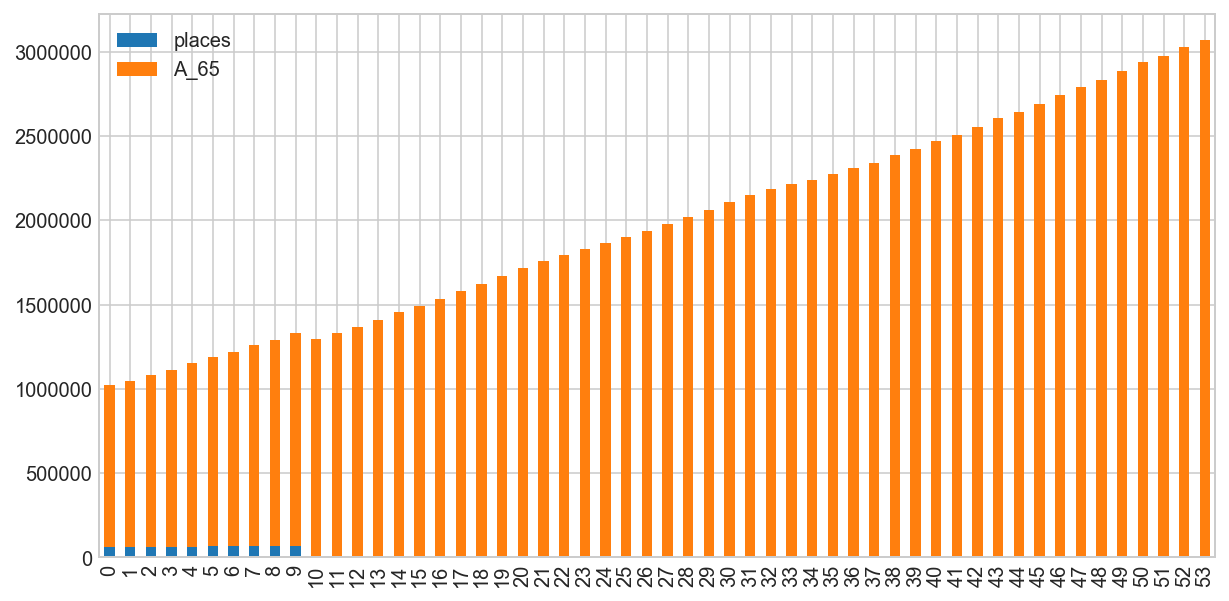

In [26]:
# check the trend of occupancy against population
total_NSW[['places', 'A_65']].plot(kind='bar', stacked=True, figsize=(10,5))

In [27]:
# check correlation
print(total_NSW.corr())

# The values positively correlated are year and population
# The values negatively correlated are year, residential places, occupancy, population

                 year    places  occupancy  pctoccupant      A_65      B_65  \
year         1.000000 -0.668075  -0.668670    -0.676118  0.999337  0.996783   
places      -0.668075  1.000000   0.999971     0.994769 -0.656940 -0.704218   
occupancy   -0.668670  0.999971   1.000000     0.995310 -0.657470 -0.704839   
pctoccupant -0.676118  0.994769   0.995310     1.000000 -0.663767 -0.712484   
A_65         0.999337 -0.656940  -0.657470    -0.663767  1.000000  0.995537   
B_65         0.996783 -0.704218  -0.704839    -0.712484  0.995537  1.000000   
C_65         0.996964 -0.703036  -0.703644    -0.711100  0.995656  0.999966   
pctplaces   -0.675873  0.995299   0.995784     0.999973 -0.663582 -0.712234   

                 C_65  pctplaces  
year         0.996964  -0.675873  
places      -0.703036   0.995299  
occupancy   -0.703644   0.995784  
pctoccupant -0.711100   0.999973  
A_65         0.995656  -0.663582  
B_65         0.999966  -0.712234  
C_65         1.000000  -0.710861  
pctplace

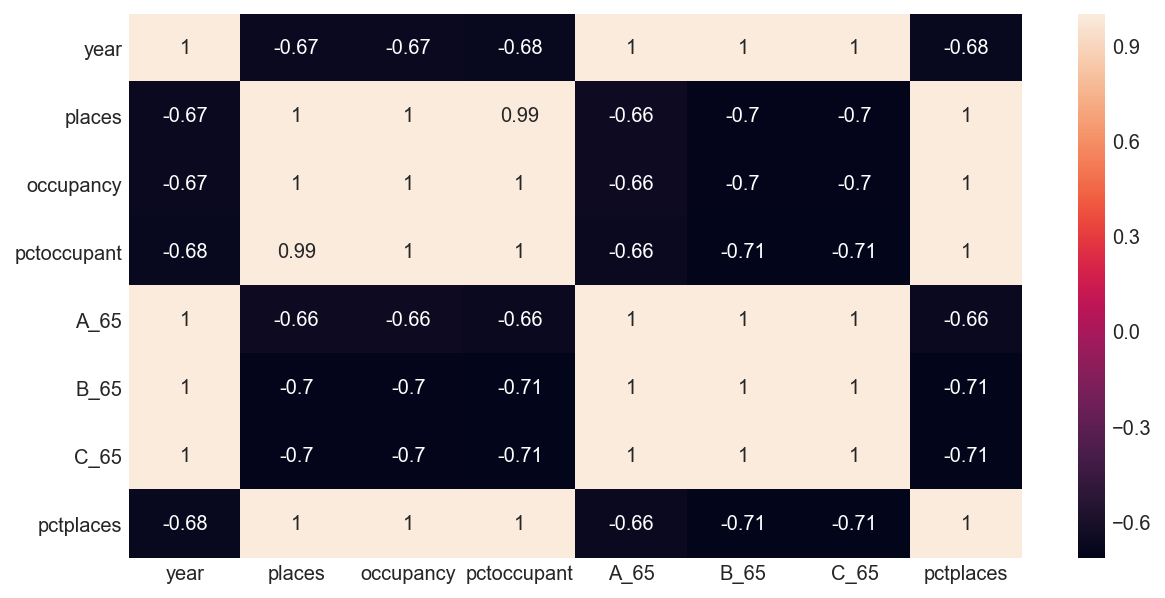

In [28]:
# Check correlation via heatmap
plt.figure(figsize=(10,5))
sns.heatmap(total_NSW.corr(), annot=True)

# The values positively correlated are year and population
# The values negatively correlated are year, residential places, occupancy, population

In [29]:
# Determine the residential beds based on suburbs for 2016-2017
SQL_STRING = '''

SELECT "PhysicalAddressSuburb","Year",SUM("Residential") AS ResBeds
FROM NSWservicelist
WHERE "PhysicalAddressState"= 'NSW' and "Year"='2016-2017' and "CareType"='Residential'
GROUP BY "PhysicalAddressSuburb","Year"
ORDER BY "ResBeds" DESC;
'''
NSW_res1 = pd.read_sql(SQL_STRING, con=conn)
NSW_res1.head()

# Bexley has the highest residential beds

,PhysicalAddressSuburb,Year,ResBeds
0,BEXLEY,2016-2017,906
1,CASTLE HILL,2016-2017,861
2,ASHFIELD,2016-2017,695
3,PORT MACQUARIE,2016-2017,676
4,GLENFIELD,2016-2017,601


In [30]:
# Determine the residential beds based on facility and facilities for 2016-2017
SQL_STRING = '''

SELECT "PhysicalAddressSuburb","Servicename",SUM("Residential") AS ResBeds
FROM NSWservicelist
WHERE "PhysicalAddressState"= 'NSW' and "Year"='2016-2017' and "CareType"='Residential'
GROUP BY "PhysicalAddressSuburb","Servicename"
ORDER BY "ResBeds" DESC;
'''
NSW_res2 = pd.read_sql(SQL_STRING, con=conn)
NSW_res2.head()

# A facility in Glenfield has the highest residential beds

,PhysicalAddressSuburb,Servicename,ResBeds
0,GLENFIELD,The Whiddon Group - Glenfield,356
1,HUNTERS HILL,Hunters Hill Montefiore Home,333
2,CESSNOCK,Calvary Cessnock Retirement Community,296
3,NARRABEEN,RSL ANZAC Village,293
4,BELROSE,Uniting Wesley Gardens Belrose,285


## Determining the distance of the aged facilities from specific locations to identify feature selections

### Assumption
* The level of government funding provided based on 2017 numbers for each facility is based on the features identified

###### Longitude and Latitude of following locations:
* Sydney CBD - (151.209900, -33.865143)
* Prince Alfred Hospital - (151.1826, -33.8895)
* Prince of Wales Hospital (Ranwick) - (151.2387, -33.9190)
* St Vincent's Hospital - (151.2208, -33.8805)
* St George Hospital - (151.1335, -33.9676)
* Bondi Beach - (151.274292, -33.89084)
* Coogee Beach - (151.2555, -33.9190)
* Maroubra Beach - (151.2437, -33.9495)
* Clovelly Beach - (151.266261, -33.913396)
* Bondi Junction - (151.2497, -33.8914)

In [31]:
# selec the residential aged care facilities for 2016-2017

SQL_STRING = '''

SELECT "Servicename","PhysicalAddressSuburb","Year","Residential","AustralianGovernmentFunding","Longitude","Latitude"
FROM  NSWservicelist
WHERE YEAR IN ('2016-2017') and ABSRemoteness='Major Cities of Australia' and CareType='Residential'
'''
service = pd.read_sql(SQL_STRING, con=conn) 
service.head()

,Servicename,PhysicalAddressSuburb,Year,Residential,AustralianGovernmentFunding,Longitude,Latitude
0,St Basil's Annandale,ANNANDALE,2016-2017,83,5146461,151.1727327,-33.87589048
1,Macquarie Lodge Aged Care Plus Centre,ARNCLIFFE,2016-2017,130,8788135,151.1348558,-33.93965582
2,A H Orr Lodge,ASHFIELD,2016-2017,60,3258005,151.1258414,-33.89495522
3,Opal Cardinal Freeman,ASHFIELD,2016-2017,135,5584660,151.127894,-33.89595
4,Weeroona Aged Care Plus Centre,BASS HILL,2016-2017,104,7057385,151.0034707,-33.89957214


In [32]:
# Check field type. Longitute and Latitute needs to be converted to numeric
service.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 555 entries, 0 to 554
Data columns (total 7 columns):
Servicename                    555 non-null object
PhysicalAddressSuburb          555 non-null object
Year                           555 non-null object
Residential                    555 non-null object
AustralianGovernmentFunding    555 non-null object
Longitude                      555 non-null object
Latitude                       555 non-null object
dtypes: object(7)
memory usage: 30.4+ KB


In [33]:
# convert the fields to numeric
service['Longitude'] = service['Longitude'].convert_objects(convert_numeric=True)
service['Latitude'] = service['Latitude'].convert_objects(convert_numeric=True)
service['AustralianGovernmentFunding'] = service['AustralianGovernmentFunding'].convert_objects(convert_numeric=True)
service['Residential'] = service['Residential'].convert_objects(convert_numeric=True)

C:\Users\lynn_\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: FutureWarning: convert_objects is deprecated.  To re-infer data dtypes for object columns, use Series.infer_objects()
For all other conversions use the data-type specific converters pd.to_datetime, pd.to_timedelta and pd.to_numeric.
  
C:\Users\lynn_\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: FutureWarning: convert_objects is deprecated.  To re-infer data dtypes for object columns, use Series.infer_objects()
For all other conversions use the data-type specific converters pd.to_datetime, pd.to_timedelta and pd.to_numeric.
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\lynn_\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: FutureWarning: convert_objects is deprecated.  To re-infer data dtypes for object columns, use Series.infer_objects()
For all other conversions use the data-type specific converters pd.to_datetime, pd.to_timedelta and pd.to_numeric.
  after remo

In [34]:
# Distance from Clovelly Beach
def haversine_np(lon1, lat1, lon2, lat2):
    """
    Calculate the great circle distance between two points
    on the earth (specified in decimal degrees)

    All args must be of equal length.    

    """
    lon1, lat1, lon2, lat2 = map(np.radians, [lon1, lat1, lon2, lat2])

    dlon = lon2 - lon1
    dlat = lat2 - lat1

    a = np.sin(dlat/2.0)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon/2.0)**2

    c = 2 * np.arcsin(np.sqrt(a))
    km = 6367 * c
    return km

service['dist_Clovelly'] = \
    haversine_np(service.Longitude.shift(0), service.Latitude.shift(0),
                 (151.266261), (-33.913396))

In [35]:
# Distance from Bondi Junction
def haversine_np(lon3, lat3, lon4, lat4):
    """
    Calculate the great circle distance between two points
    on the earth (specified in decimal degrees)

    All args must be of equal length.    

    """
    lon3, lat3, lon4, lat4 = map(np.radians, [lon3, lat3, lon4, lat4])

    dlon = lon4 - lon3
    dlat = lat4 - lat3

    a = np.sin(dlat/2.0)**2 + np.cos(lat3) * np.cos(lat4) * np.sin(dlon/2.0)**2

    c = 2 * np.arcsin(np.sqrt(a))
    km = 6367 * c
    return km

service['dist_BondiJunction'] = \
    haversine_np(service.Longitude.shift(0), service.Latitude.shift(0),
                 (151.2497), (-33.8914))

In [36]:
# Distance from Maroubra Beach
def haversine_np(lon5, lat5, lon6, lat6):
    """
    Calculate the great circle distance between two points
    on the earth (specified in decimal degrees)

    All args must be of equal length.    

    """
    lon5, lat5, lon6, lat6 = map(np.radians, [lon5, lat5, lon6, lat6])

    dlon = lon6 - lon5
    dlat = lat6 - lat5

    a = np.sin(dlat/2.0)**2 + np.cos(lat5) * np.cos(lat6) * np.sin(dlon/2.0)**2

    c = 2 * np.arcsin(np.sqrt(a))
    km = 6367 * c
    return km

service['dist_Maroubra'] = \
    haversine_np(service.Longitude.shift(0), service.Latitude.shift(0),
                 (151.2437), (-33.9495))

In [37]:
# Distance from Coogee Beach
def haversine_np(lon7, lat7, lon8, lat8):
    """
    Calculate the great circle distance between two points
    on the earth (specified in decimal degrees)

    All args must be of equal length.    

    """
    lon7, lat7, lon8, lat8 = map(np.radians, [lon7, lat7, lon8, lat8])

    dlon = lon8 - lon7
    dlat = lat8 - lat7

    a = np.sin(dlat/2.0)**2 + np.cos(lat7) * np.cos(lat8) * np.sin(dlon/2.0)**2

    c = 2 * np.arcsin(np.sqrt(a))
    km = 6367 * c
    return km

service['dist_Coogee'] = \
    haversine_np(service.Longitude.shift(0), service.Latitude.shift(0),
                 (151.2555), (-33.9190))

In [38]:
# Distance from St Vincent's Hospital
def haversine_np(lon9, lat9, lon10, lat10):
    """
    Calculate the great circle distance between two points
    on the earth (specified in decimal degrees)

    All args must be of equal length.    

    """
    lon9, lat9, lon10, lat10 = map(np.radians, [lon9, lat9, lon10, lat10])

    dlon = lon10 - lon9
    dlat = lat10 - lat9

    a = np.sin(dlat/2.0)**2 + np.cos(lat9) * np.cos(lat10) * np.sin(dlon/2.0)**2

    c = 2 * np.arcsin(np.sqrt(a))
    km = 6367 * c
    return km

service['dist_Vincent'] = \
    haversine_np(service.Longitude.shift(0), service.Latitude.shift(0),
                 (151.2208), (-33.8805))

In [39]:
# Distance from Sydney CBD
def haversine_np(lon11, lat11, lon12, lat12):
    """
    Calculate the great circle distance between two points
    on the earth (specified in decimal degrees)

    All args must be of equal length.    

    """
    lon11, lat11, lon12, lat12 = map(np.radians, [lon11, lat11, lon12, lat12])

    dlon = lon12 - lon11
    dlat = lat12 - lat11

    a = np.sin(dlat/2.0)**2 + np.cos(lat11) * np.cos(lat12) * np.sin(dlon/2.0)**2

    c = 2 * np.arcsin(np.sqrt(a))
    km = 6367 * c
    return km

service['dist_CBD'] = \
    haversine_np(service.Longitude.shift(0), service.Latitude.shift(0),
                 (151.209900), (-33.865143))

In [40]:
# Distance from Prince Alfred Hospital
def haversine_np(lon13, lat13, lon14, lat14):
    """
    Calculate the great circle distance between two points
    on the earth (specified in decimal degrees)

    All args must be of equal length.    

    """
    lon13, lat13, lon14, lat14 = map(np.radians, [lon13, lat13, lon14, lat14])

    dlon = lon14 - lon13
    dlat = lat14 - lat13

    a = np.sin(dlat/2.0)**2 + np.cos(lat13) * np.cos(lat14) * np.sin(dlon/2.0)**2

    c = 2 * np.arcsin(np.sqrt(a))
    km = 6367 * c
    return km

service['dist_Alfred'] = \
    haversine_np(service.Longitude.shift(0), service.Latitude.shift(0),
                 (151.1826), (-33.8895))

In [41]:
# Distance from Prince of Wales Hospital
def haversine_np(lon15, lat15, lon16, lat16):
    """
    Calculate the great circle distance between two points
    on the earth (specified in decimal degrees)

    All args must be of equal length.    

    """
    lon15, lat15, lon16, lat16 = map(np.radians, [lon15, lat15, lon16, lat16])

    dlon = lon16 - lon15
    dlat = lat16 - lat15

    a = np.sin(dlat/2.0)**2 + np.cos(lat15) * np.cos(lat16) * np.sin(dlon/2.0)**2

    c = 2 * np.arcsin(np.sqrt(a))
    km = 6367 * c
    return km

service['dist_Wales'] = \
    haversine_np(service.Longitude.shift(0), service.Latitude.shift(0),
                 (151.2387), (-33.9190))

In [42]:
# Distance from St George Hospital
def haversine_np(lon17, lat17, lon18, lat18):
    """
    Calculate the great circle distance between two points
    on the earth (specified in decimal degrees)

    All args must be of equal length.    

    """
    lon17, lat17, lon18, lat18 = map(np.radians, [lon17, lat17, lon18, lat18])

    dlon = lon18 - lon17
    dlat = lat18 - lat17

    a = np.sin(dlat/2.0)**2 + np.cos(lat17) * np.cos(lat18) * np.sin(dlon/2.0)**2

    c = 2 * np.arcsin(np.sqrt(a))
    km = 6367 * c
    return km

service['dist_StGeorge'] = \
    haversine_np(service.Longitude.shift(0), service.Latitude.shift(0),
                 (151.1335), (-33.9676))

In [43]:
# Distance from Bondi Beach
def haversine_np(lon19, lat19, lon20, lat20):
    """
    Calculate the great circle distance between two points
    on the earth (specified in decimal degrees)

    All args must be of equal length.    

    """
    lon19, lat19, lon20, lat20 = map(np.radians, [lon19, lat19, lon20, lat20])

    dlon = lon20 - lon19
    dlat = lat20 - lat19

    a = np.sin(dlat/2.0)**2 + np.cos(lat19) * np.cos(lat20) * np.sin(dlon/2.0)**2

    c = 2 * np.arcsin(np.sqrt(a))
    km = 6367 * c
    return km

service['dist_Bondi'] = \
    haversine_np(service.Longitude.shift(0), service.Latitude.shift(0),
                 (151.274292), (-33.89084))

In [44]:
# Check the dataframe
service.head(1)

,Servicename,PhysicalAddressSuburb,Year,Residential,AustralianGovernmentFunding,Longitude,Latitude,dist_Clovelly,dist_BondiJunction,dist_Maroubra,dist_Coogee,dist_Vincent,dist_CBD,dist_Alfred,dist_Wales,dist_StGeorge,dist_Bondi
0,St Basil's Annandale,ANNANDALE,2016-2017,83,5146461,151.172733,-33.87589,9.581138,7.306635,10.475849,9.012864,4.464116,3.631338,1.765183,7.744212,10.814297,9.515312


In [45]:
# write the new dataframe into the database to the table feature_NSW
service.to_sql(name = 'feature_NSW', con = conn, if_exists = 'replace', index = False)